In [59]:
# Import Dependencies
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import os
import random
from contextlib import contextmanager
from time import time
from tqdm import tqdm
import lightgbm as lgbm
# import category_encoders as ce
from sklearn.metrics import classification_report, log_loss, accuracy_score
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
import warnings
warnings.filterwarnings('ignore')

# Clean the Spotify Data

In [60]:
# Read in csv file
df = pd.read_csv('Resources/SpotifyDataSet.csv')
df.head()

,Unnamed: 0,track_id,artists,album_name,track_name,popularity,duration_ms,explicit,danceability,energy,...,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,time_signature,track_genre
0,0,5SuOikwiRyPMVoIQDJUgSV,Gen Hoshino,Comedy,Comedy,73,230666,False,0.676,0.4610,...,-6.746,0,0.1430,0.0322,0.000001,0.3580,0.715,87.917,4,acoustic
1,1,4qPNDBW1i3p13qLCt0Ki3A,Ben Woodward,Ghost (Acoustic),Ghost - Acoustic,55,149610,False,0.420,0.1660,...,-17.235,1,0.0763,0.9240,0.000006,0.1010,0.267,77.489,4,acoustic
2,2,1iJBSr7s7jYXzM8EGcbK5b,Ingrid Michaelson;ZAYN,To Begin Again,To Begin Again,57,210826,False,0.438,0.3590,...,-9.734,1,0.0557,0.2100,0.000000,0.1170,0.120,76.332,4,acoustic
3,3,6lfxq3CG4xtTiEg7opyCyx,Kina Grannis,Crazy Rich Asians (Original Motion Picture Sou...,Can't Help Falling In Love,71,201933,False,0.266,0.0596,...,-18.515,1,0.0363,0.9050,0.000071,0.1320,0.143,181.740,3,acoustic
4,4,5vjLSffimiIP26QG5WcN2K,Chord Overstreet,Hold On,Hold On,82,198853,False,0.618,0.4430,...,-9.681,1,0.0526,0.4690,0.000000,0.0829,0.167,119.949,4,acoustic


In [61]:
# Get columns descriptions and review data for null values

df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 114000 entries, 0 to 113999
Data columns (total 21 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   Unnamed: 0        114000 non-null  int64  
 1   track_id          114000 non-null  object 
 2   artists           113999 non-null  object 
 3   album_name        113999 non-null  object 
 4   track_name        113999 non-null  object 
 5   popularity        114000 non-null  int64  
 6   duration_ms       114000 non-null  int64  
 7   explicit          114000 non-null  bool   
 8   danceability      114000 non-null  float64
 9   energy            114000 non-null  float64
 10  key               114000 non-null  int64  
 11  loudness          114000 non-null  float64
 12  mode              114000 non-null  int64  
 13  speechiness       114000 non-null  float64
 14  acousticness      114000 non-null  float64
 15  instrumentalness  114000 non-null  float64
 16  liveness          11

In [62]:
df.describe()

,Unnamed: 0,popularity,duration_ms,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,time_signature
count,114000.000000,114000.000000,1.140000e+05,114000.000000,114000.000000,114000.000000,114000.000000,114000.000000,114000.000000,114000.000000,114000.000000,114000.000000,114000.000000,114000.000000,114000.000000
mean,56999.500000,33.238535,2.280292e+05,0.566800,0.641383,5.309140,-8.258960,0.637553,0.084652,0.314910,0.156050,0.213553,0.474068,122.147837,3.904035
std,32909.109681,22.305078,1.072977e+05,0.173542,0.251529,3.559987,5.029337,0.480709,0.105732,0.332523,0.309555,0.190378,0.259261,29.978197,0.432621
min,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,-49.531000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,28499.750000,17.000000,1.740660e+05,0.456000,0.472000,2.000000,-10.013000,0.000000,0.035900,0.016900,0.000000,0.098000,0.260000,99.218750,4.000000
50%,56999.500000,35.000000,2.129060e+05,0.580000,0.685000,5.000000,-7.004000,1.000000,0.048900,0.169000,0.000042,0.132000,0.464000,122.017000,4.000000
75%,85499.250000,50.000000,2.615060e+05,0.695000,0.854000,8.000000,-5.003000,1.000000,0.084500,0.598000,0.049000,0.273000,0.683000,140.071000,4.000000
max,113999.000000,100.000000,5.237295e+06,0.985000,1.000000,11.000000,4.532000,1.000000,0.965000,0.996000,1.000000,1.000000,0.995000,243.372000,5.000000


In [63]:
# Drop rows with null values & duplicate tracks
df.dropna()

df = df.drop_duplicates(
  subset = ['artists','track_name'],
  keep = 'first')

In [64]:
df.describe()

,Unnamed: 0,popularity,duration_ms,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,time_signature
count,81344.000000,81344.000000,8.134400e+04,81344.000000,81344.000000,81344.000000,81344.000000,81344.000000,81344.000000,81344.000000,81344.000000,81344.000000,81344.000000,81344.000000,81344.000000
mean,53670.537151,34.635966,2.314117e+05,0.559275,0.635025,5.285922,-8.593940,0.632339,0.088992,0.329670,0.184731,0.219721,0.463280,122.145034,3.896968
std,33488.412880,19.438777,1.164945e+05,0.177746,0.258639,3.557612,5.304765,0.482171,0.116628,0.339961,0.331591,0.198271,0.263383,30.128881,0.456396
min,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,-49.531000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,24074.750000,21.000000,1.738710e+05,0.446000,0.455000,2.000000,-10.451250,0.000000,0.036100,0.015900,0.000000,0.098500,0.241000,99.408000,4.000000
50%,50566.500000,35.000000,2.152040e+05,0.573000,0.678000,5.000000,-7.262000,1.000000,0.049100,0.190000,0.000089,0.133000,0.449000,122.030000,4.000000
75%,80721.250000,49.000000,2.673460e+05,0.690000,0.857000,8.000000,-5.140000,1.000000,0.087000,0.629000,0.153000,0.283000,0.676000,140.128250,4.000000
max,113999.000000,100.000000,5.237295e+06,0.985000,1.000000,11.000000,4.532000,1.000000,0.965000,0.996000,1.000000,1.000000,0.995000,243.372000,5.000000


In [65]:
# Remove unnecessary columns

df = df[['track_id', 'artists', 'album_name', 'track_name',
       'popularity', 'duration_ms', 'explicit', 'danceability', 'energy',
       'key', 'loudness', 'mode', 'speechiness', 'acousticness',
       'instrumentalness', 'liveness', 'valence', 'tempo', 'time_signature',
       'track_genre']]

In [66]:
# Confirm output file and export data into a csv

df.to_csv('Output/Cleaned_Spotify_Data.csv',header=True,index=False)


# Data Analysis

In [67]:
# Count the frequency of each artist
df["artists"].value_counts()

George Jones                                             215
my little airport                                        163
The Beatles                                              149
Håkan Hellström                                          122
Scooter                                                  116
                                                        ... 
George Dalaras;Emma Shapplin                               1
Frankie Knuckles;Director's Cut;Eric Kupper;Inaya Day      1
Carlos Paredes                                             1
George Dalaras;Babis Stokas                                1
Jesus Culture                                              1
Name: artists, Length: 31437, dtype: int64

The above summary does show a limitation of the data as songs where there has been a collaboration between artists are being treated as a separate "artist" category which can skew the data for Top Artists as features and collabs are not counted.

In [68]:
# Count the value of each genre
df["track_genre"].value_counts()

study          996
black-metal    991
comedy         987
heavy-metal    985
bluegrass      978
              ... 
rock           167
reggae         166
house          134
indie          107
reggaeton       63
Name: track_genre, Length: 113, dtype: int64

In [69]:
# Groupby popular tracks to see the highest popularity of each genre
popular_tracks = df.groupby('track_genre')['popularity'].max()
popular_tracks.head(25)

track_genre
acoustic           82
afrobeat           75
alt-rock           93
alternative        86
ambient            84
anime              83
black-metal        58
bluegrass          69
blues              79
brazil             82
breakbeat          66
british            87
cantopop           72
chicago-house      78
children           77
chill              93
classical          71
club               85
comedy             75
country            86
dance             100
dancehall          75
death-metal        65
deep-house         76
detroit-techno     58
Name: popularity, dtype: int64

In [70]:

# Groupby popular tracks to sum their total popularity
popular_tracks2 = df.groupby('track_genre')['popularity'].sum()
popular_tracks2.head(25)

track_genre
acoustic          40757
afrobeat          23429
alt-rock          31197
alternative        8184
ambient           41994
anime             45816
black-metal       22162
bluegrass         25199
blues             26804
brazil            41520
breakbeat         19098
british           37353
cantopop          33316
chicago-house     11705
children          31368
chill             50182
classical         11027
club              31566
comedy            24298
country           14136
dance             18561
dancehall         30044
death-metal       28293
deep-house        42451
detroit-techno    10259
Name: popularity, dtype: int64

## Attributes

The data includes attributes for each track such as speechiness, danceability, energy which are all scored from 0 to 1. As well as objective characteristics of the song such as length, mode and key.

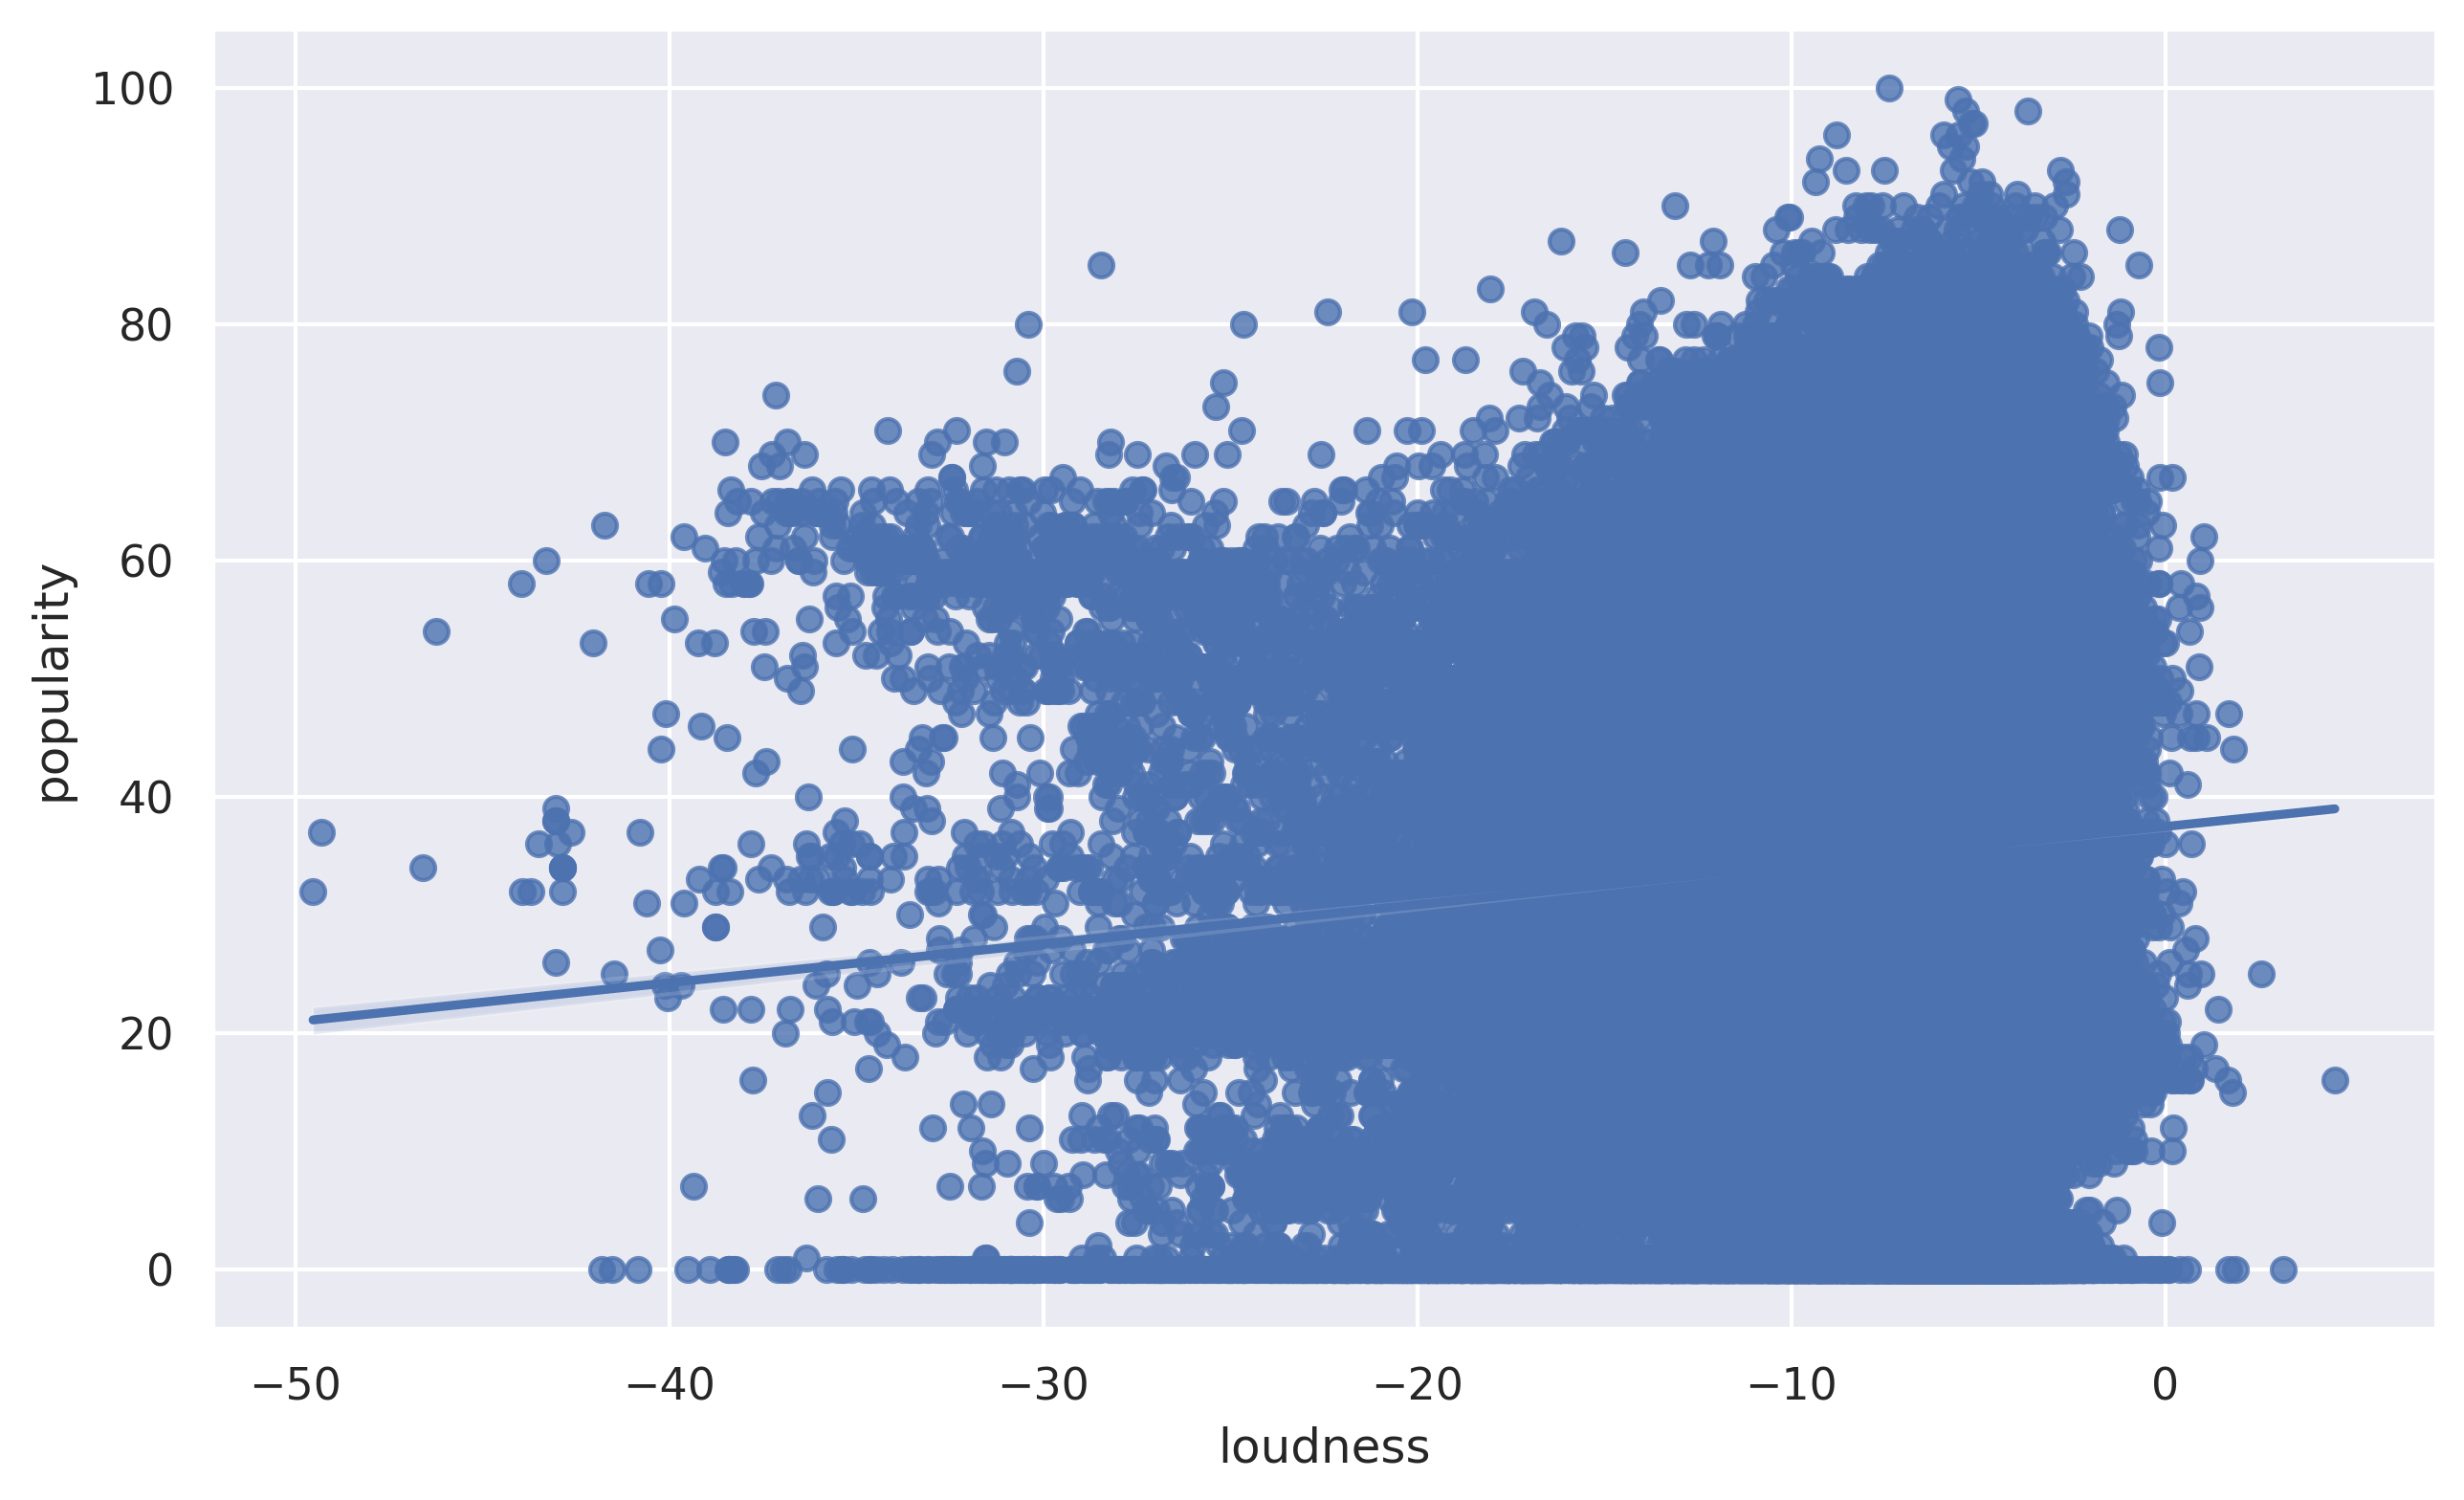

In [71]:
# Plot the Loudness vs Popularity
sns.set()
plt.figure(figsize=(10, 6), dpi=300)
sns.regplot(x='loudness', y='popularity', data=df)

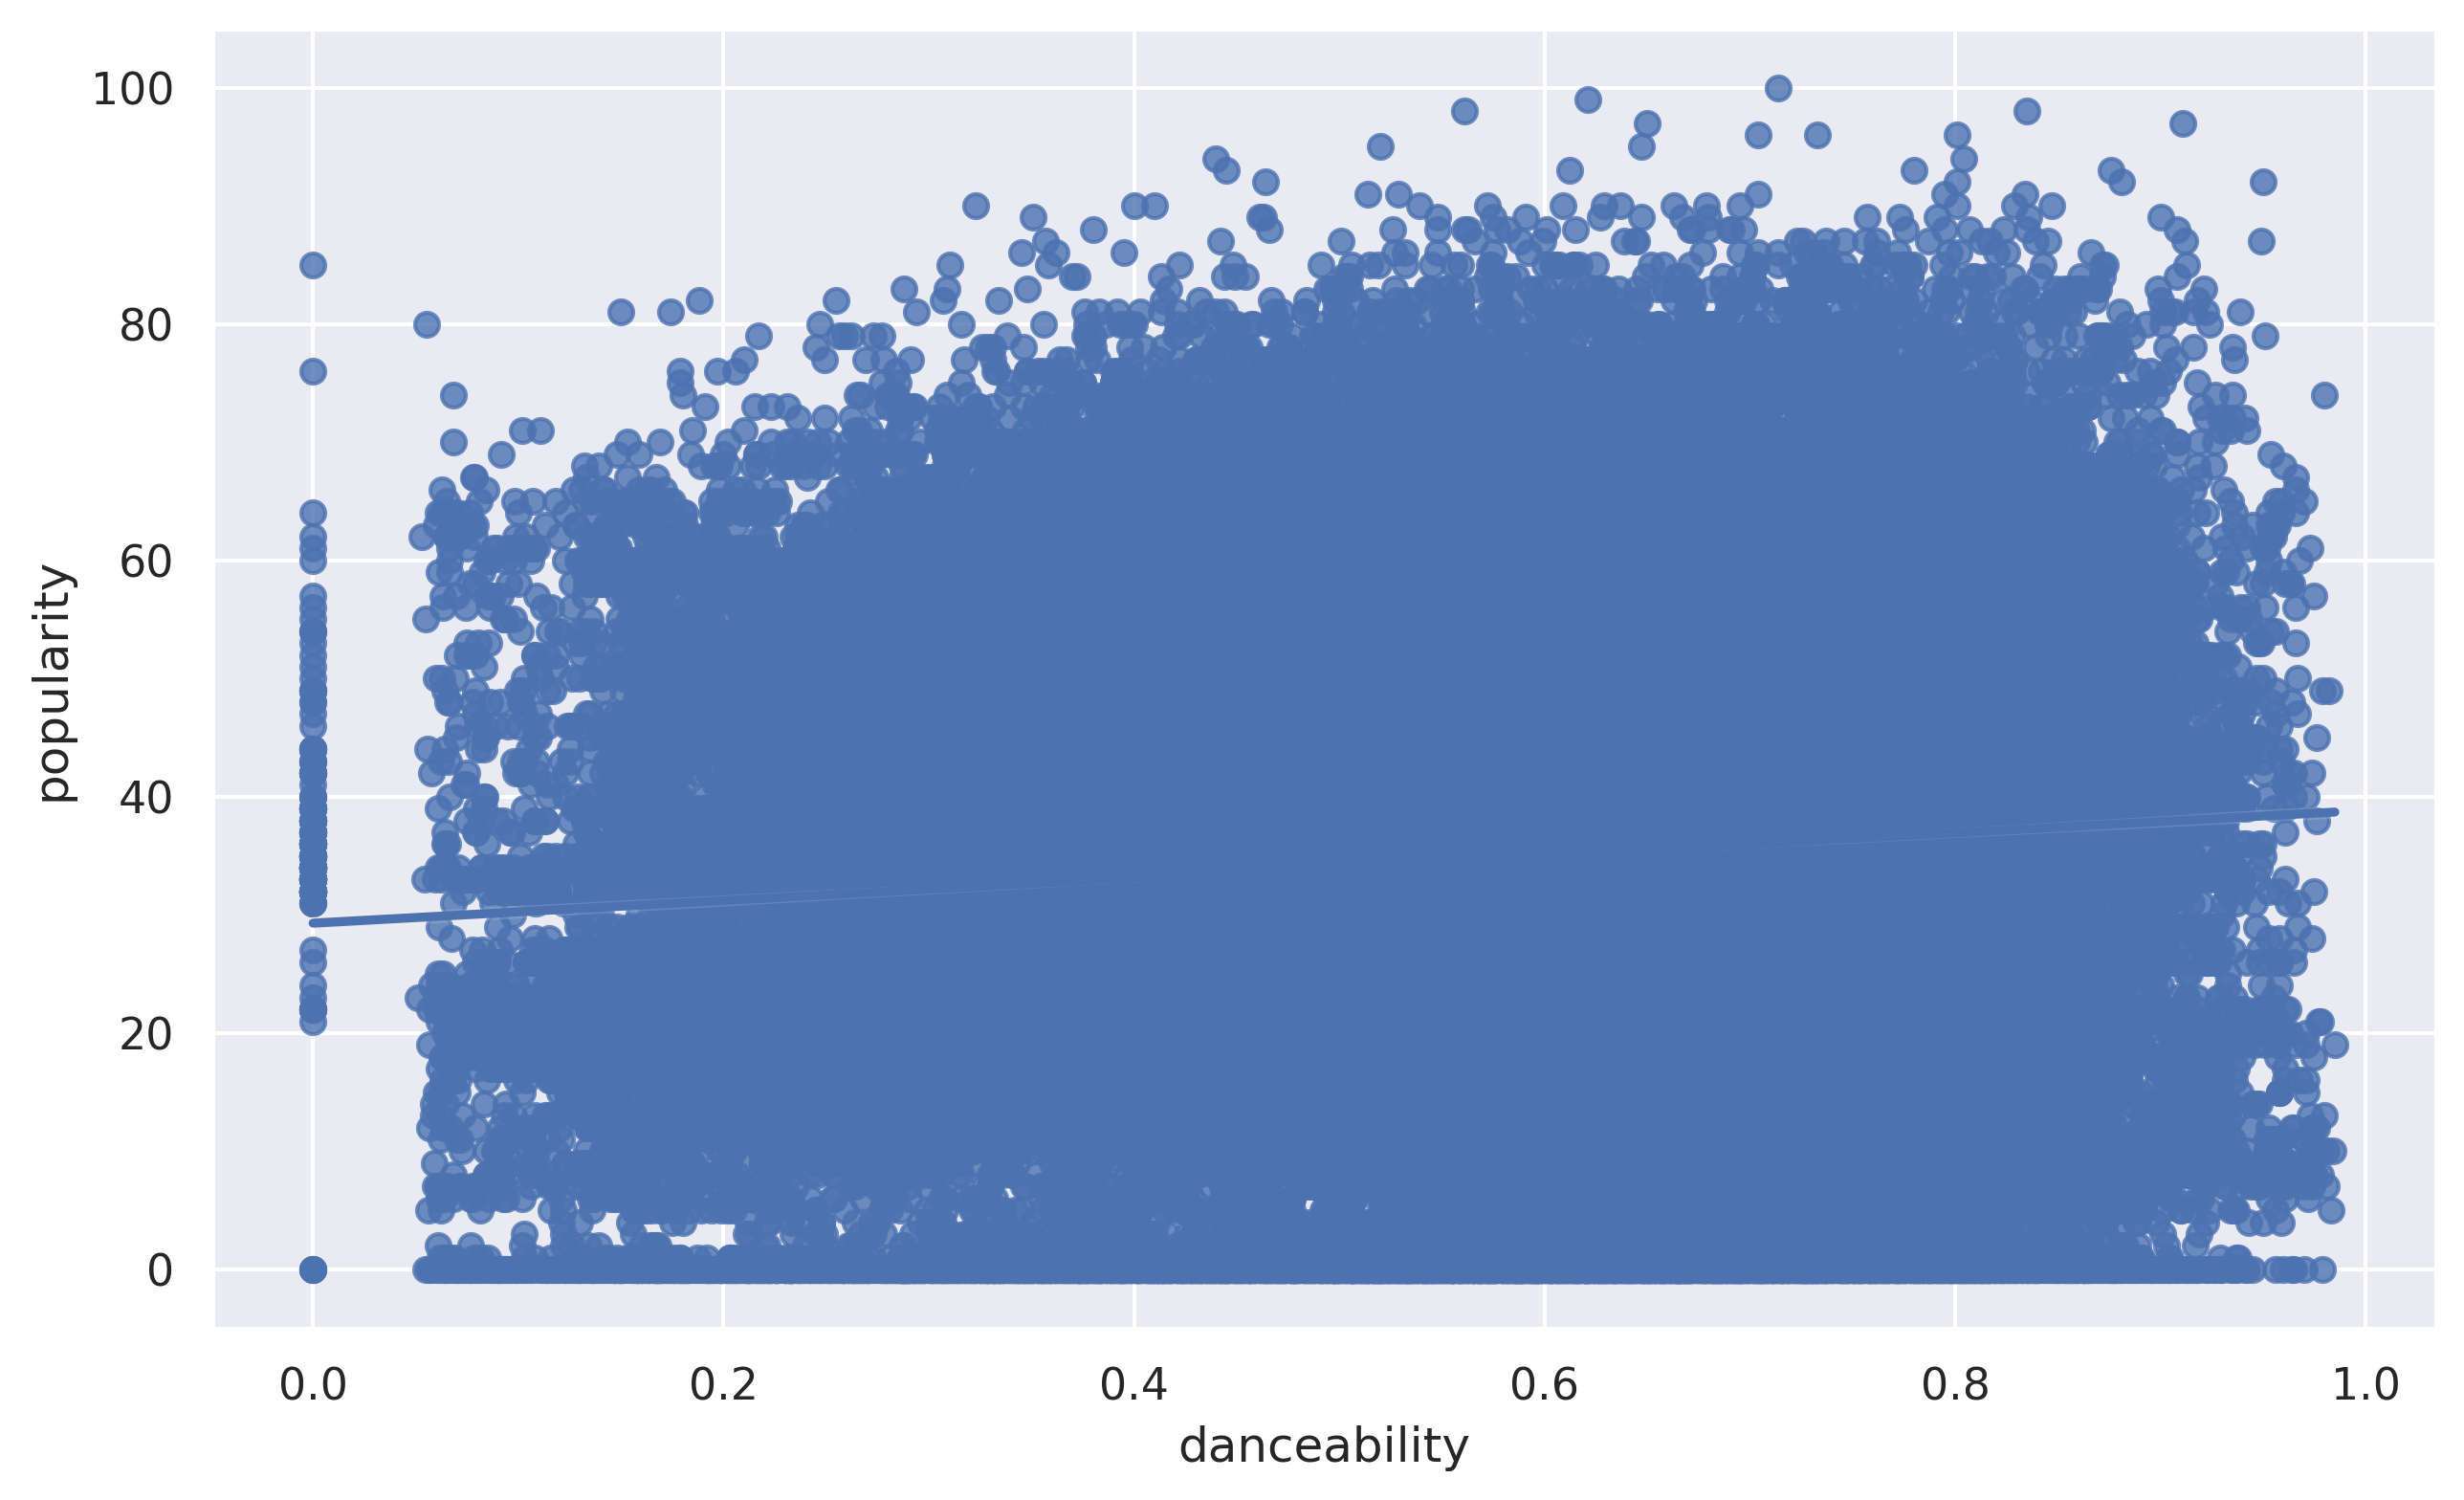

In [72]:
# Plot Danceability vs Popularity
sns.set()
plt.figure(figsize=(10, 6), dpi=300)
sns.regplot(x='danceability', y='popularity', data=df)

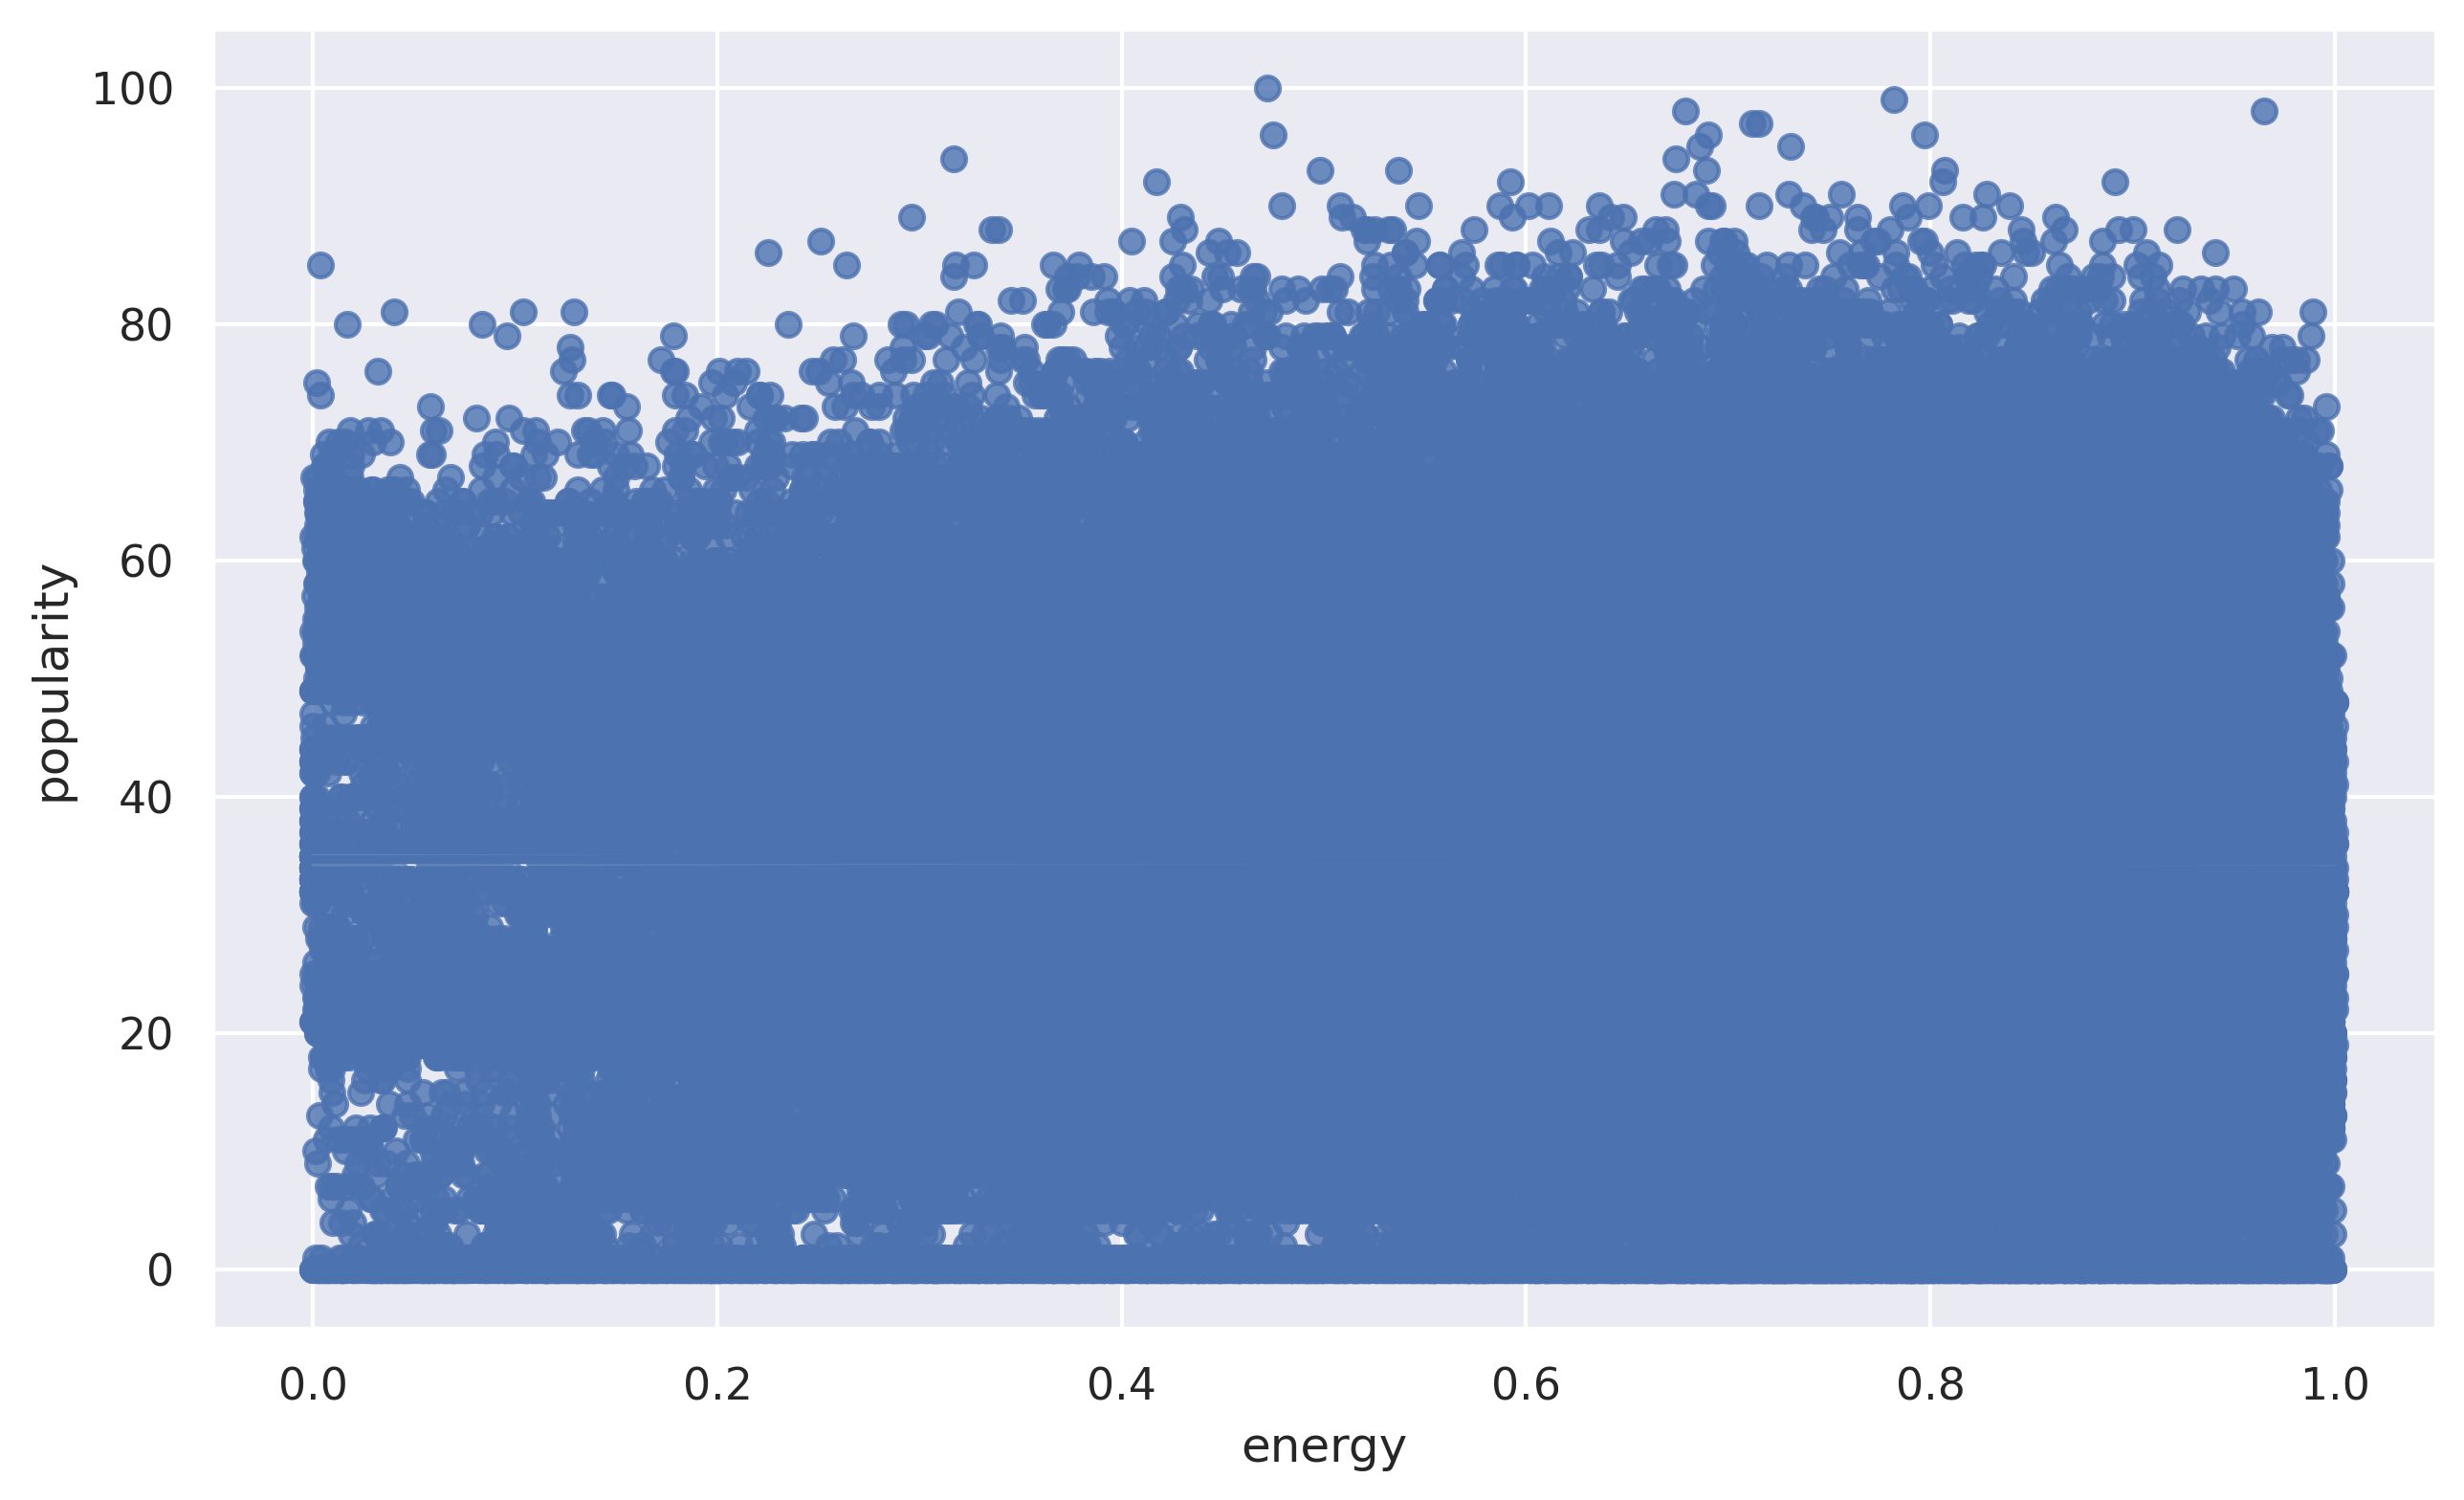

In [73]:
# Plot Energy vs Popularity
sns.set()
plt.figure(figsize=(10, 6), dpi=300)
sns.regplot(x='energy', y='popularity', data=df)

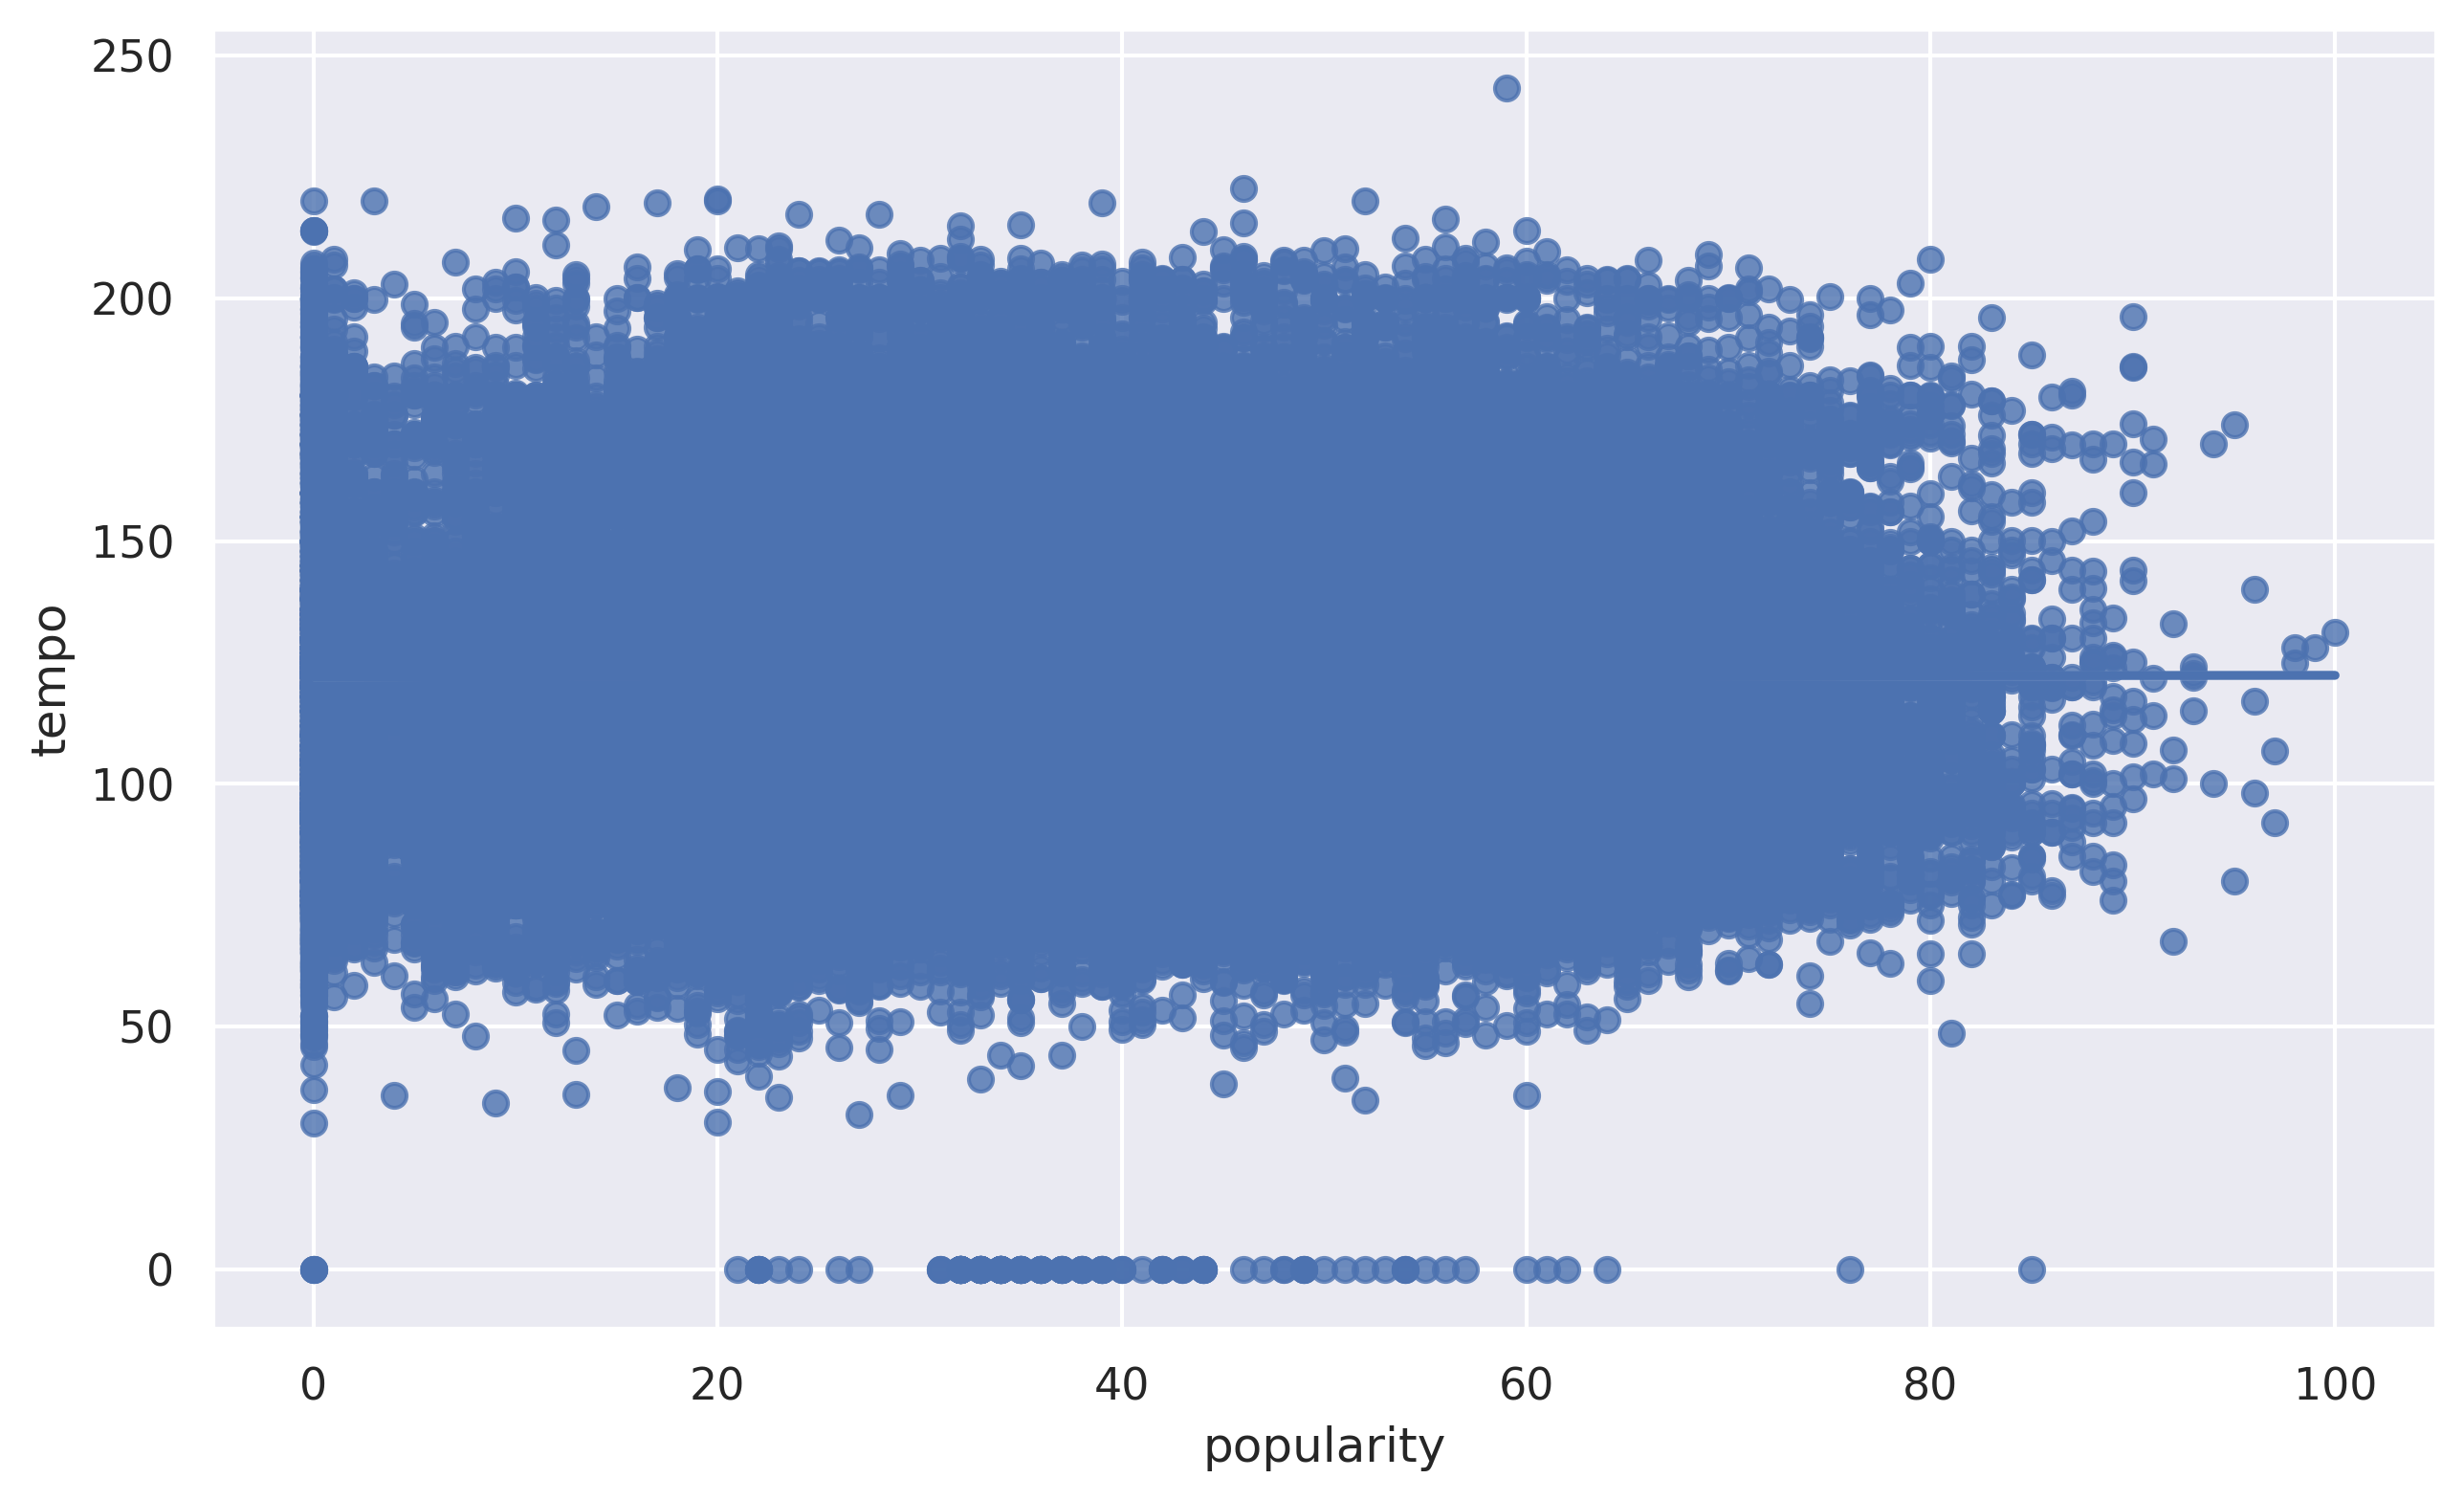

In [74]:
# Plot Tempo vs Popularity
sns.set()
plt.figure(figsize=(10, 6), dpi=300)
sns.regplot(x='popularity', y='tempo', data=df)

In comparing Loudness, Danceability, Energy, Tempo with Popularity there isn't a strong correlation between the characteristics and Popularity. Out of the four attributes Loudness is the most positively correlated with Popularity. Which is interesting that Energy doesn't have a similar correlation with popularity given the strong correlation between Loudness and Energy as we can see below.

In [75]:
# Visualize the correlation between the characteristics of each track
px.imshow(df.corr())

In [76]:
# Visualize the top genres by popularity
top_genres = df.groupby('track_genre').mean().sort_values('popularity', ascending=False)
px.bar(top_genres, x=top_genres.index, y='popularity')

In [77]:
#Top Ten Genres from above
genres = [
    'k-pop',
    'metal',
    'chill',
    'sad',
    'grunge',
    'indian',
    'piano',
    'anime',
    'indie-pop',
    'house',
]

In [78]:
#Visualise Top 10 Artists for the Top Ten Genres identified

fig = make_subplots(rows=4, cols=4, vertical_spacing=0.16, subplot_titles = genres)
row=1
col=1

for genre in genres:
    top_artists = df.query('track_genre == @genre')
    top_artists = top_artists.groupby(by='artists').mean().sort_values('popularity', ascending=False)
    top_artists = top_artists.loc[~top_artists.index.str.contains(';')]
    top_artists = top_artists.head(10)
    
    fig.add_trace(
    go.Bar(name=genre, x=top_artists.index, y=top_artists['popularity']),
    row=row, col=col)
    
    col += 1
    if (col == 5):
        col = 1
        row += 1
    
    fig.update_layout(height=2000, width=1000, title_text="10 Most Popular Artists in Specific Genres, by Average Popularity")
    
fig.show()

# Machine Learning

In [79]:
# Classify x & y
y = df['popularity']
X = df[['energy', 'danceability', 'duration_ms', 'tempo']]

In [80]:
# Split the data into X_train, X_test, y_train, y_test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.8, random_state=42)

lr = LinearRegression()
lr.fit(X_train, y_train)
pred = lr.predict(X_test)

In [81]:
# View Coefficients of the Linear Regression
new_df =  pd.DataFrame(lr.coef_, X.columns, columns=['Coefficient'])
new_df

,Coefficient
energy,-1.888018
danceability,10.316388
duration_ms,-0.000008
tempo,0.002189


In [82]:
# View training data comapred to test predictions
df_model = pd.DataFrame({'Actual': y_test, 'Predicted': pred})
df_model

,Actual,Predicted
21103,75,37.222220
79565,59,34.713041
13676,8,36.125958
98101,36,34.764002
9080,51,32.668333
...,...,...
4595,27,32.387134
22081,31,32.876675
8985,0,35.025191
84997,25,35.427175


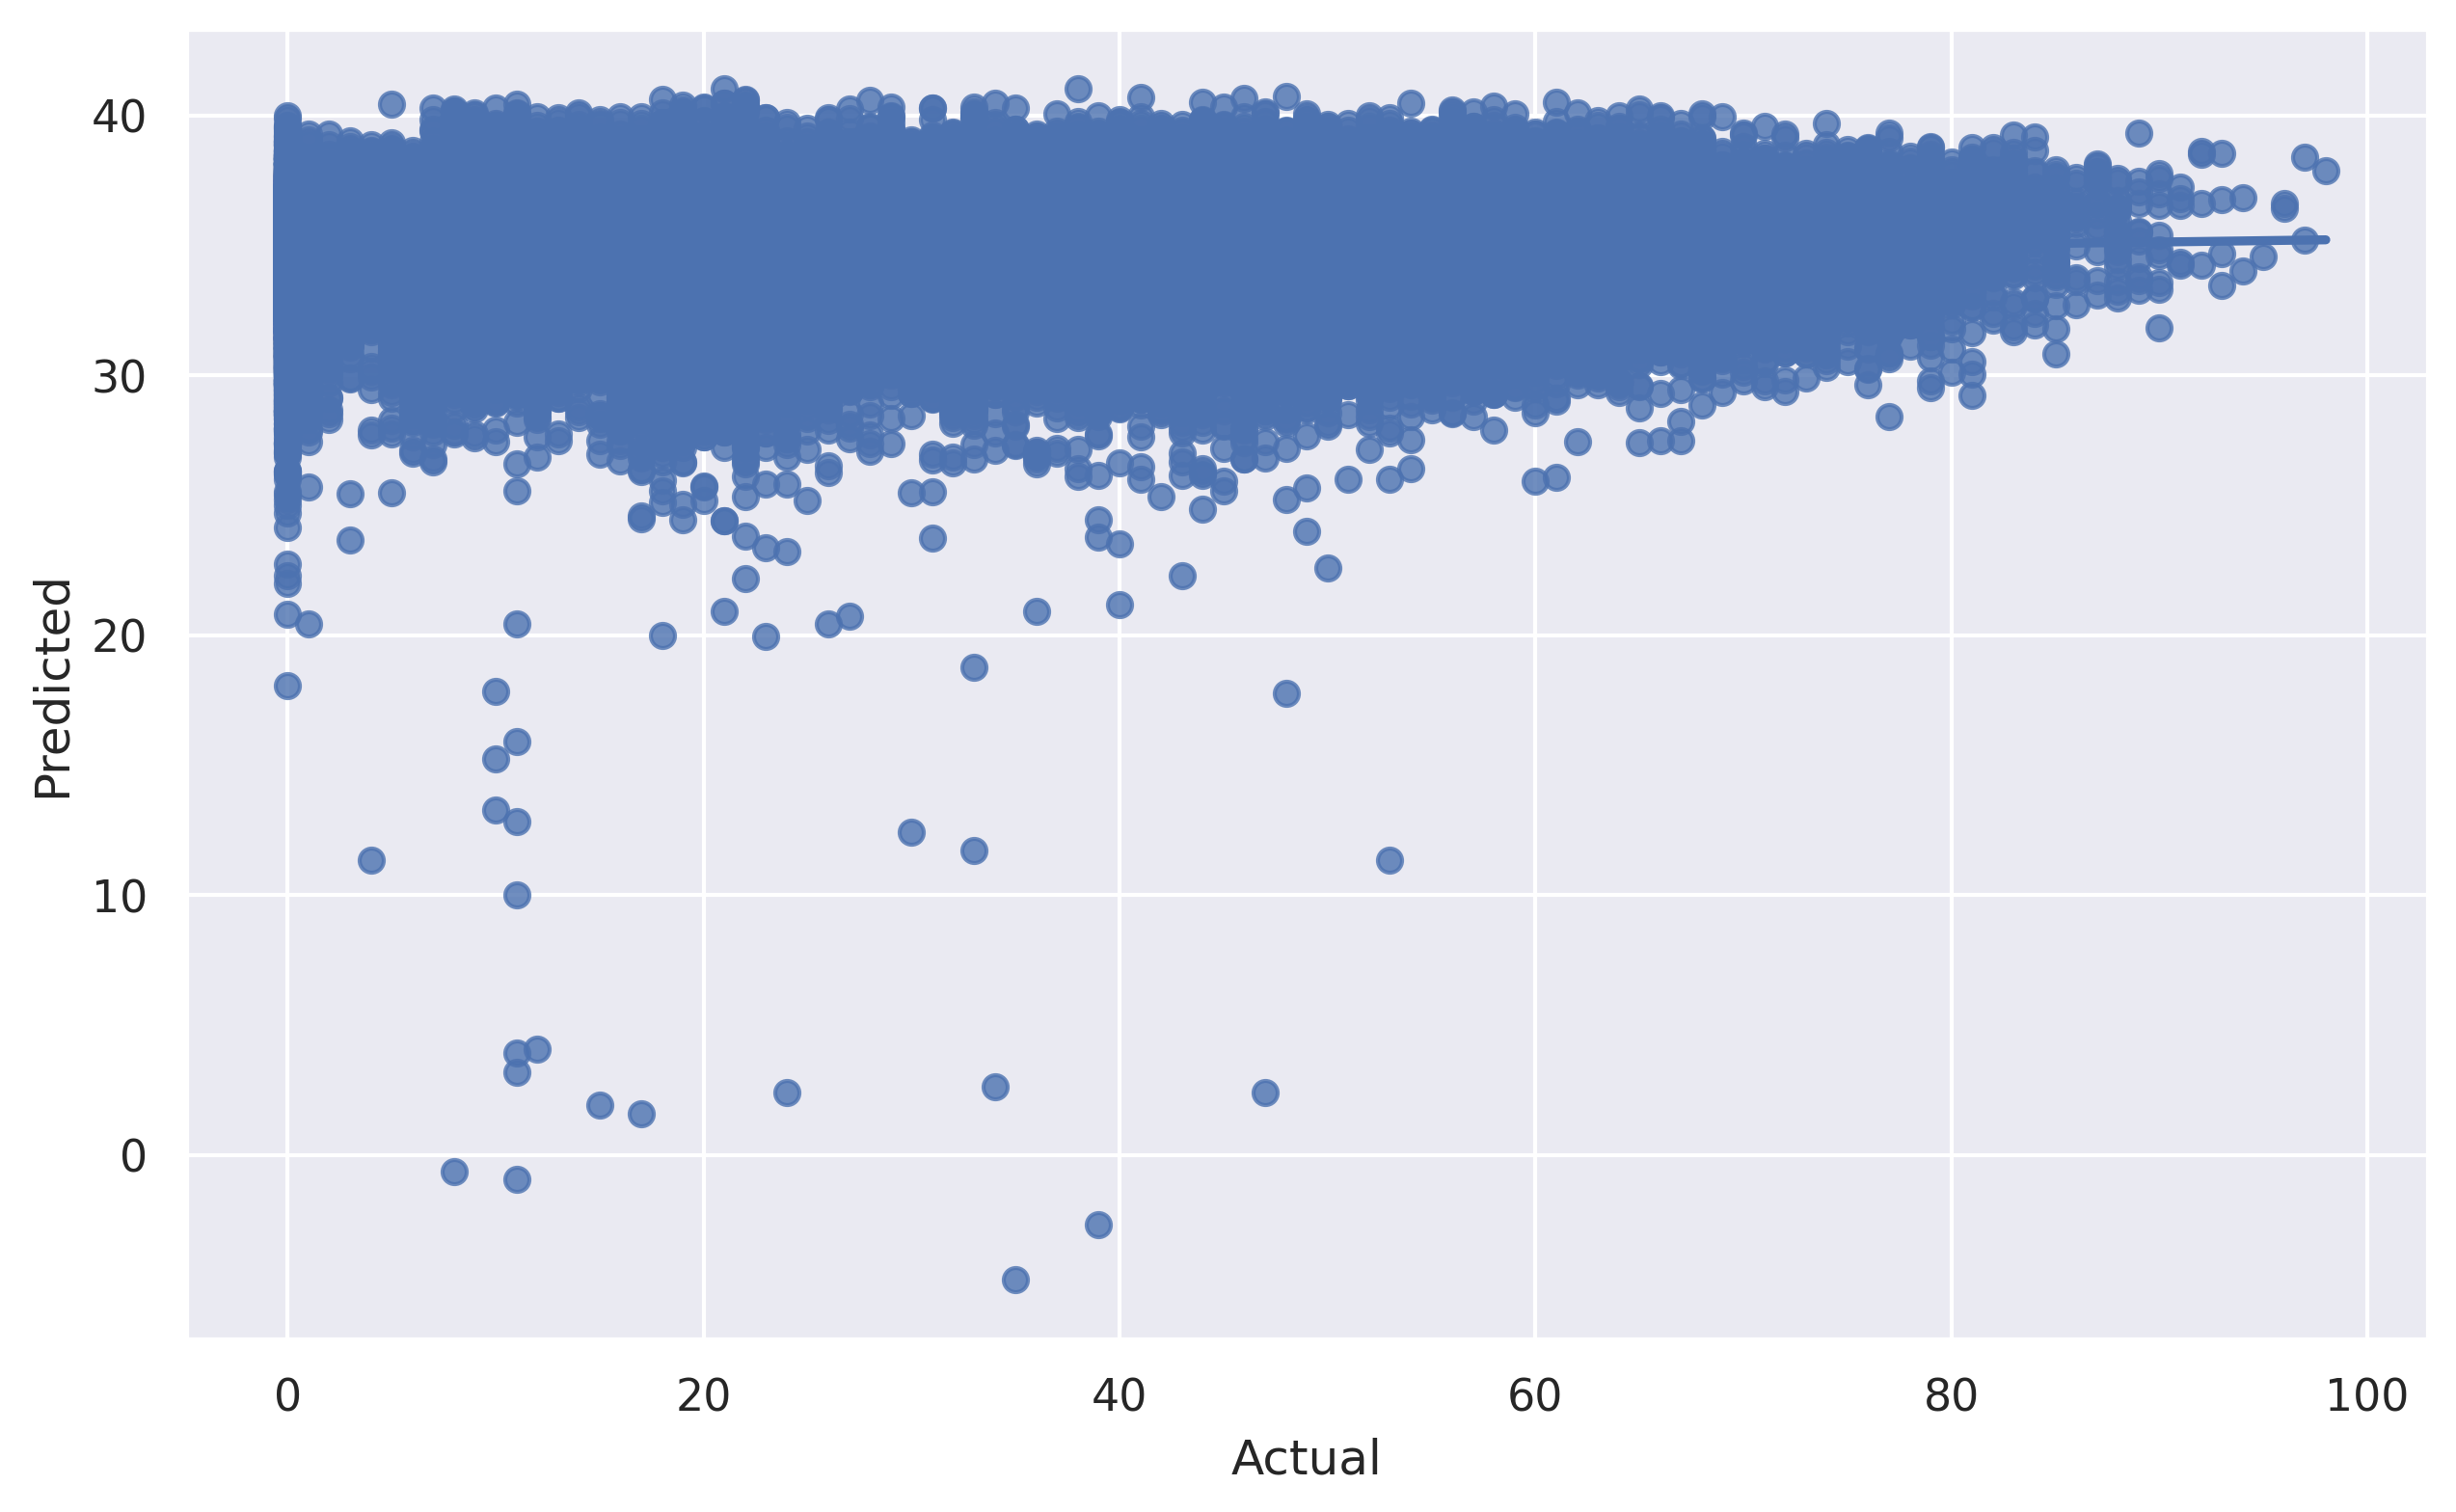

In [83]:
# Visualise actual vs Predictions
sns.set()
plt.figure(figsize=(10, 6), dpi=300)
sns.regplot(x='Actual', y='Predicted', data=df_model)

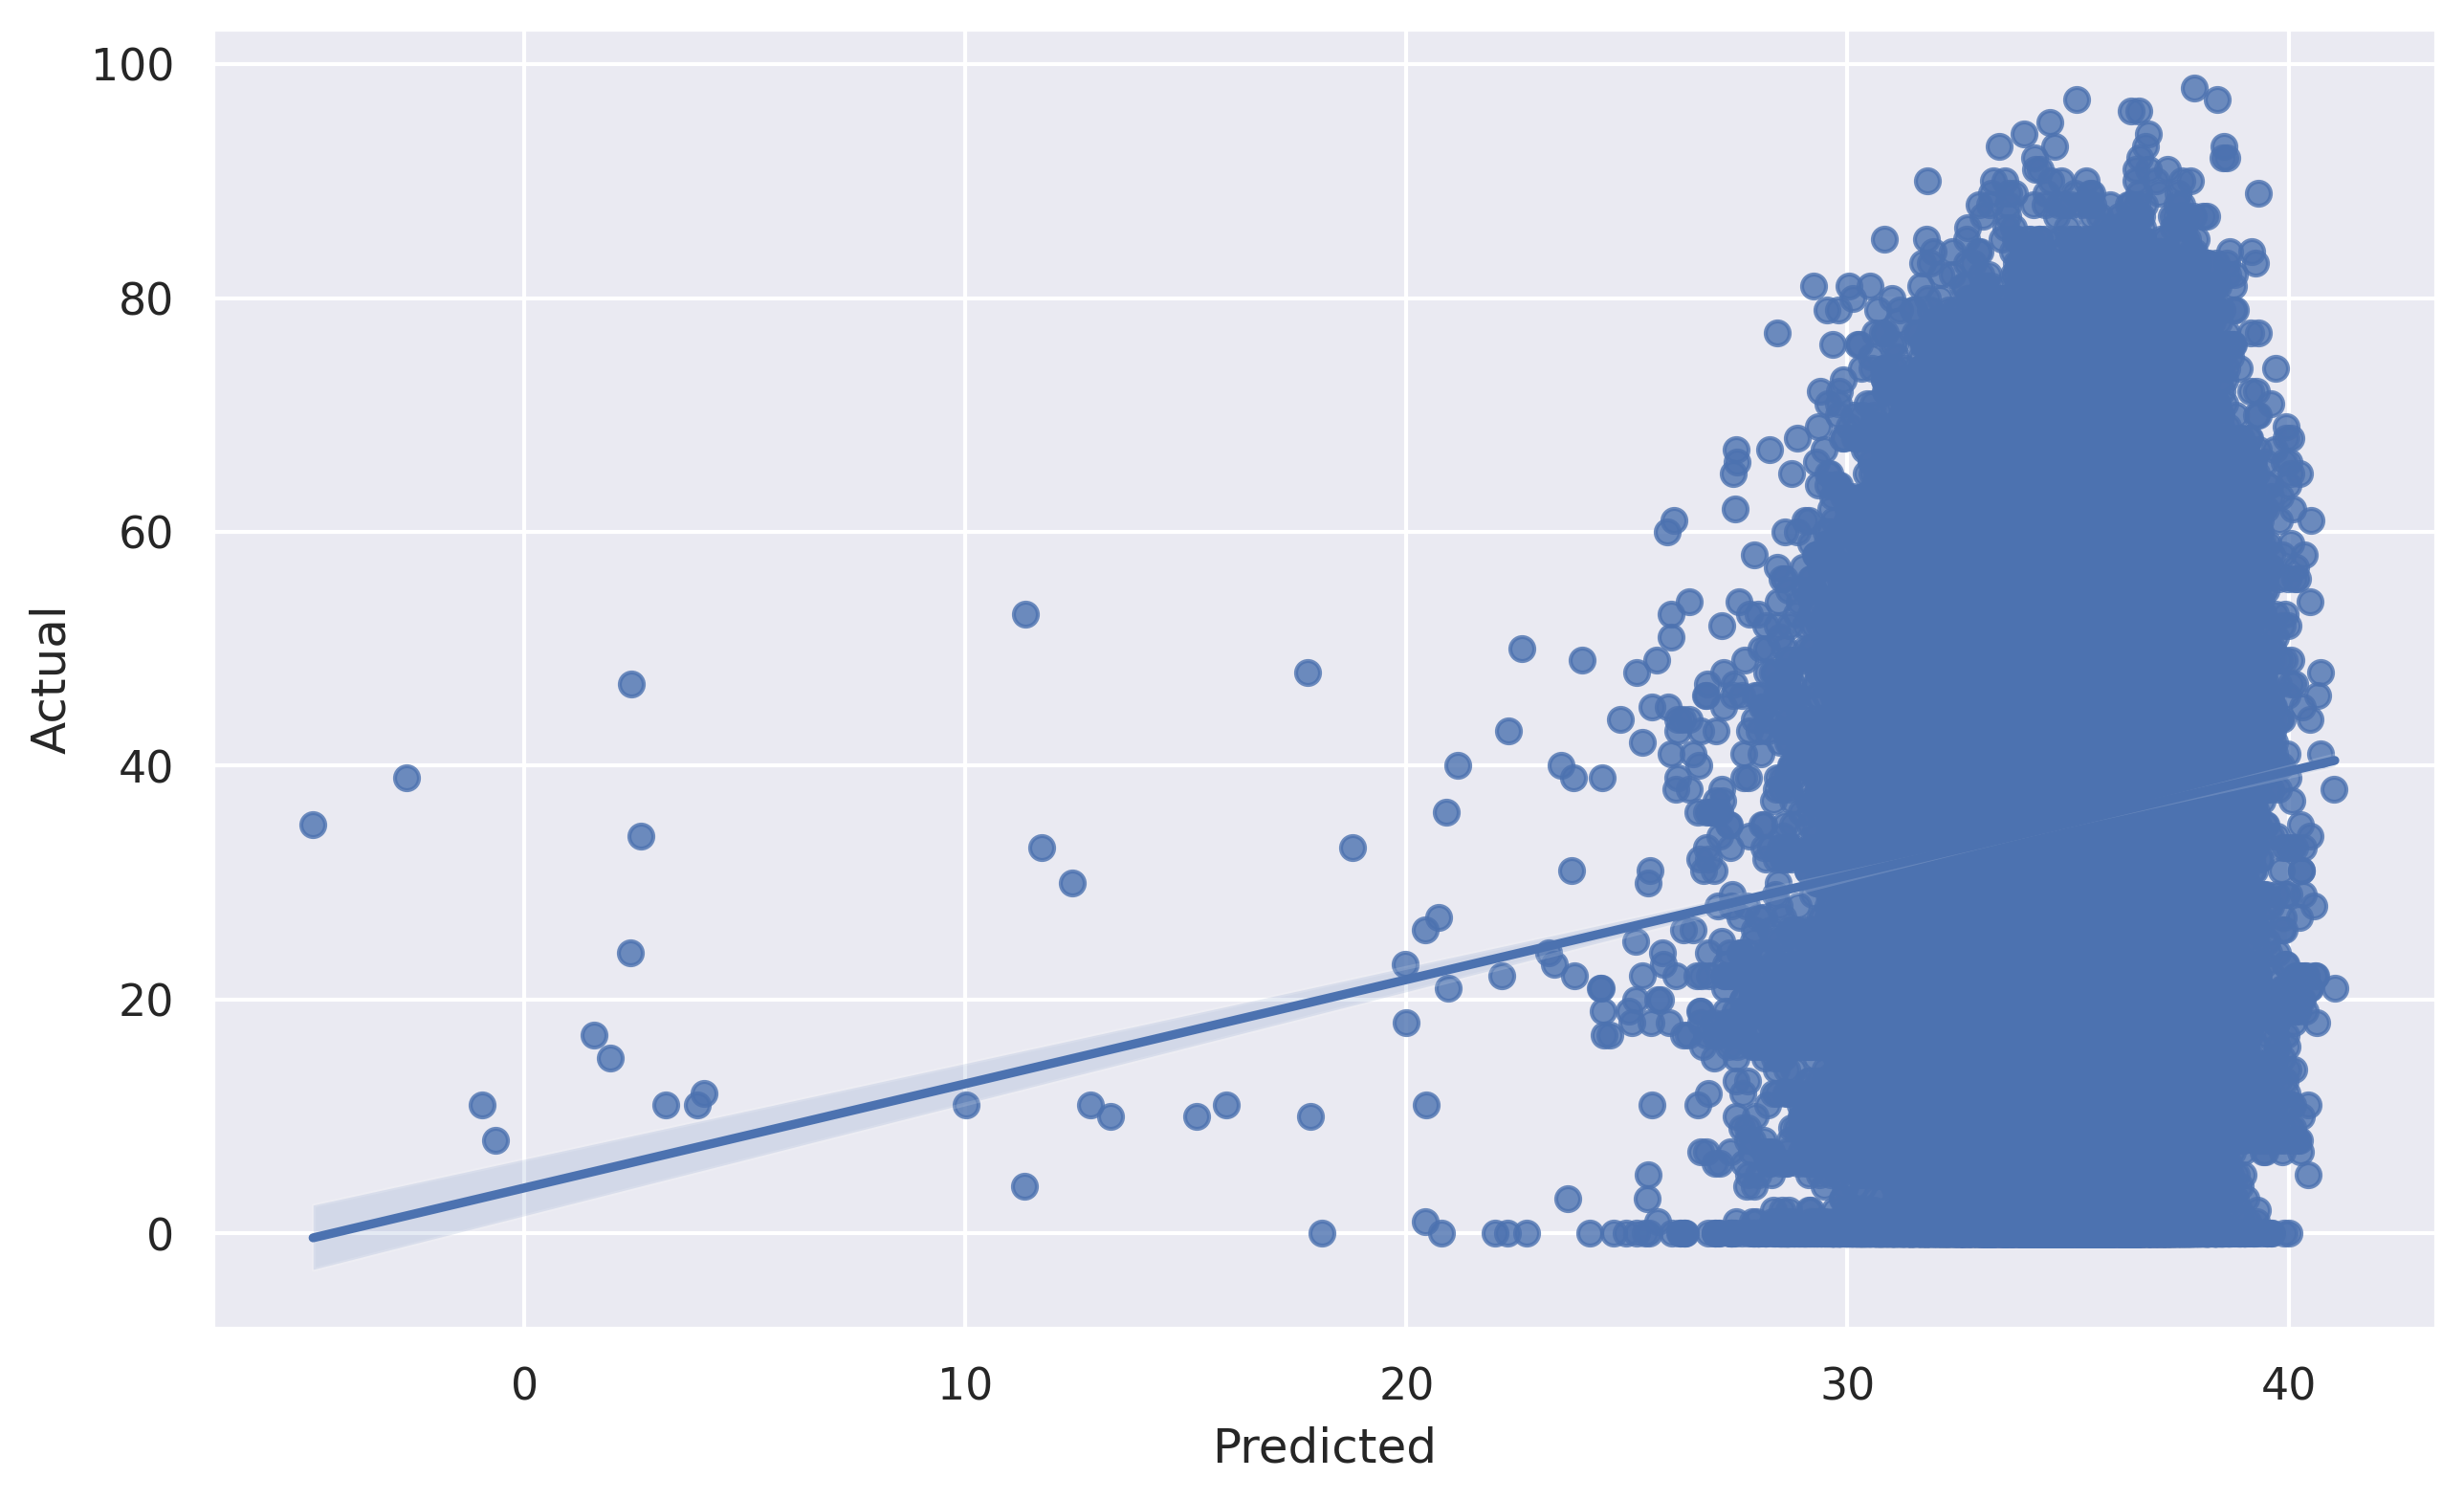

In [84]:
sns.set()
plt.figure(figsize=(10, 6), dpi=300)
sns.regplot(x='Predicted', y='Actual', data=df_model)

In [85]:
# Make deep copy of cleaned df
df.copy(deep=True)

,track_id,artists,album_name,track_name,popularity,duration_ms,explicit,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,time_signature,track_genre
0,5SuOikwiRyPMVoIQDJUgSV,Gen Hoshino,Comedy,Comedy,73,230666,False,0.676,0.4610,1,-6.746,0,0.1430,0.0322,0.000001,0.3580,0.7150,87.917,4,acoustic
1,4qPNDBW1i3p13qLCt0Ki3A,Ben Woodward,Ghost (Acoustic),Ghost - Acoustic,55,149610,False,0.420,0.1660,1,-17.235,1,0.0763,0.9240,0.000006,0.1010,0.2670,77.489,4,acoustic
2,1iJBSr7s7jYXzM8EGcbK5b,Ingrid Michaelson;ZAYN,To Begin Again,To Begin Again,57,210826,False,0.438,0.3590,0,-9.734,1,0.0557,0.2100,0.000000,0.1170,0.1200,76.332,4,acoustic
3,6lfxq3CG4xtTiEg7opyCyx,Kina Grannis,Crazy Rich Asians (Original Motion Picture Sou...,Can't Help Falling In Love,71,201933,False,0.266,0.0596,0,-18.515,1,0.0363,0.9050,0.000071,0.1320,0.1430,181.740,3,acoustic
4,5vjLSffimiIP26QG5WcN2K,Chord Overstreet,Hold On,Hold On,82,198853,False,0.618,0.4430,2,-9.681,1,0.0526,0.4690,0.000000,0.0829,0.1670,119.949,4,acoustic
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
113995,2C3TZjDRiAzdyViavDJ217,Rainy Lullaby,#mindfulness - Soft Rain for Mindful Meditatio...,Sleep My Little Boy,21,384999,False,0.172,0.2350,5,-16.393,1,0.0422,0.6400,0.928000,0.0863,0.0339,125.995,5,world-music
113996,1hIz5L4IB9hN3WRYPOCGPw,Rainy Lullaby,#mindfulness - Soft Rain for Mindful Meditatio...,Water Into Light,22,385000,False,0.174,0.1170,0,-18.318,0,0.0401,0.9940,0.976000,0.1050,0.0350,85.239,4,world-music
113997,6x8ZfSoqDjuNa5SVP5QjvX,Cesária Evora,Best Of,Miss Perfumado,22,271466,False,0.629,0.3290,0,-10.895,0,0.0420,0.8670,0.000000,0.0839,0.7430,132.378,4,world-music
113998,2e6sXL2bYv4bSz6VTdnfLs,Michael W. Smith,Change Your World,Friends,41,283893,False,0.587,0.5060,7,-10.889,1,0.0297,0.3810,0.000000,0.2700,0.4130,135.960,4,world-music


In [86]:
# Initialize labelencoder

def labelencoder(df):
    for c in df.columns:
        if df[c].dtype=='object': 
            df[c] = df[c].fillna('N')
            lbl = LabelEncoder()
            lbl.fit(list(df[c].values))
            df[c] = lbl.transform(df[c].values)
    return df

In [87]:
data1=labelencoder(df.iloc[:,1:])

In [88]:
target=['popularity']
dataY=data1[target]
dataX=data1.drop(target,axis=1)

In [89]:
df_columns = list(dataX.columns)
print(df_columns)

['artists', 'album_name', 'track_name', 'duration_ms', 'explicit', 'danceability', 'energy', 'key', 'loudness', 'mode', 'speechiness', 'acousticness', 'instrumentalness', 'liveness', 'valence', 'tempo', 'time_signature', 'track_genre']


In [90]:
m=len(dataX)
print(m)
M=list(range(m))
random.seed(2021)
random.shuffle(M)

trainX=dataX.iloc[M[0:(m//4)*3]]
trainY=dataY.iloc[M[0:(m//4)*3]]
testX=dataX.iloc[M[(m//4)*3:]]
testY=dataY.iloc[M[(m//4)*3:]]

81344


In [91]:
train_df=trainX
test_df=testX


In [92]:
train_df.columns=df_columns
test_df.columns=df_columns

In [93]:
def create_numeric_feature(input_df):
    use_columns = df_columns 
    return input_df[use_columns].copy()

In [94]:
class Timer:
    def __init__(self, logger=None, format_str='{:.3f}[s]', prefix=None, suffix=None, sep=' '):

        if prefix: format_str = str(prefix) + sep + format_str
        if suffix: format_str = format_str + sep + str(suffix)
        self.format_str = format_str
        self.logger = logger
        self.start = None
        self.end = None

    @property
    def duration(self):
        if self.end is None:
            return 0
        return self.end - self.start

    def __enter__(self):
        self.start = time()

    def __exit__(self, exc_type, exc_val, exc_tb):
        self.end = time()
        out_str = self.format_str.format(self.duration)
        if self.logger:
            self.logger.info(out_str)
        else:
            print(out_str)

In [95]:
def to_feature(input_df):

    processors = [
        create_numeric_feature,
    ]
    
    out_df = pd.DataFrame()
    
    for func in tqdm(processors, total=len(processors)):
        with Timer(prefix='create' + func.__name__ + ' '):
            _df = func(input_df)

        assert len(_df) == len(input_df), func.__name__
        out_df = pd.concat([out_df, _df], axis=1)
        
    return out_df

In [96]:
train_feat_df = to_feature(train_df)
test_feat_df = to_feature(test_df)

100%|██████████| 1/1 [00:00<00:00, 58.66it/s]

createcreate_numeric_feature  0.010[s]



100%|██████████| 1/1 [00:00<00:00, 111.48it/s]

createcreate_numeric_feature  0.004[s]


In [97]:
def fit_lgbm(X, y, cv, 
             params: dict=None, 
             verbose: int=50):

    if params is None:
        params = {}

    models = []
    oof_pred = np.zeros_like(y, dtype=np.float)

    for i, (idx_train, idx_valid) in enumerate(cv): 
        x_train, y_train = X[idx_train], y[idx_train]
        x_valid, y_valid = X[idx_valid], y[idx_valid]

        clf = lgbm.LGBMRegressor(**params)
        
        with Timer(prefix='fit fold={} '.format(i)):
            clf.fit(x_train, y_train, 
                    eval_set=[(x_valid, y_valid)],  
                    early_stopping_rounds=100,
                    verbose=verbose)

        pred_i = clf.predict(x_valid)
        oof_pred[idx_valid] = pred_i
        models.append(clf)
        print(f'Fold {i} RMSLE: {mean_squared_error(y_valid, pred_i) ** .5:.4f}')
        print()

    score = mean_squared_error(y, oof_pred) ** .5
    print('-' * 50)
    print('FINISHED | Whole RMSLE: {:.4f}'.format(score))
    return oof_pred, models

In [98]:
params = {
    'objective': 'rmse', 
    'learning_rate': .1,
    'reg_lambda': 1.,
    'reg_alpha': .1,
    'max_depth': 5, 
    'n_estimators': 10000, 
    'colsample_bytree': .5, 
    'min_child_samples': 10,
    'subsample_freq': 3,
    'subsample': .9,
    'importance_type': 'gain', 
    'random_state': 71,
    'num_leaves': 62
}

In [99]:
y = trainY
ydf=pd.DataFrame(y)
ydf

,popularity
45981,21
17609,29
97668,47
60775,19
60273,24
...,...
48269,0
78764,25
44206,64
38505,50


Training until validation scores don't improve for 100 rounds.
[500]	valid_0's rmse: 14.3166
[1000]	valid_0's rmse: 14.1083
[1500]	valid_0's rmse: 14.0535
Early stopping, best iteration is:
[1746]	valid_0's rmse: 14.0219
fit fold=0  12.262[s]
Fold 0 RMSLE: 14.0218

Training until validation scores don't improve for 100 rounds.
[500]	valid_0's rmse: 14.3659
[1000]	valid_0's rmse: 14.1268
[1500]	valid_0's rmse: 14.0734
[2000]	valid_0's rmse: 14.0367
Early stopping, best iteration is:
[1959]	valid_0's rmse: 14.0321
fit fold=1  13.896[s]
Fold 1 RMSLE: 14.0321

Training until validation scores don't improve for 100 rounds.
[500]	valid_0's rmse: 14.2221
[1000]	valid_0's rmse: 13.9851
Early stopping, best iteration is:
[1396]	valid_0's rmse: 13.9428
fit fold=2  9.565[s]
Fold 2 RMSLE: 13.9428

Training until validation scores don't improve for 100 rounds.
[500]	valid_0's rmse: 14.1829
[1000]	valid_0's rmse: 13.9114
[1500]	valid_0's rmse: 13.8522
Early stopping, best iteration is:
[1687]	valid_

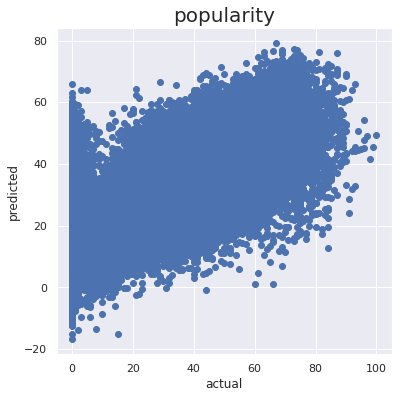

In [100]:
for i in range(1):
    fold = KFold(n_splits=5, shuffle=True, random_state=71)
    ydfi=ydf.iloc[:,i]
    y=np.array(ydfi)
    cv = list(fold.split(train_feat_df, y))
    oof, models = fit_lgbm(train_feat_df.values, y, cv, params=params, verbose=500)
    
    fig,ax = plt.subplots(figsize=(6,6))
    ax.set_title(target[i],fontsize=20)
    ax.set_ylabel('predicted',fontsize=12)
    ax.set_xlabel('actual',fontsize=12)
    ax.scatter(y,oof)

In [101]:
def visualize_importance(models, feat_train_df):

    feature_importance_df = pd.DataFrame()
    for i, model in enumerate(models):
        _df = pd.DataFrame()
        _df['feature_importance'] = model.feature_importances_
        _df['column'] = feat_train_df.columns
        _df['fold'] = i + 1
        feature_importance_df = pd.concat([feature_importance_df, _df], 
                                          axis=0, ignore_index=True)

    order = feature_importance_df.groupby('column')\
        .sum()[['feature_importance']]\
        .sort_values('feature_importance', ascending=False).index[:50]

    fig, ax = plt.subplots(figsize=(8, max(6, len(order) * .25)))
    sns.boxenplot(data=feature_importance_df, 
                  x='feature_importance', 
                  y='column', 
                  order=order, 
                  ax=ax, 
                  palette='viridis', 
                  orient='h')
    
    ax.tick_params(axis='x', rotation=0)
    #ax.set_title('Importance')
    ax.grid()
    fig.tight_layout()
    
    return fig,ax

Training until validation scores don't improve for 100 rounds.
[500]	valid_0's rmse: 14.3166
[1000]	valid_0's rmse: 14.1083
[1500]	valid_0's rmse: 14.0535
Early stopping, best iteration is:
[1746]	valid_0's rmse: 14.0219
fit fold=0  12.294[s]
Fold 0 RMSLE: 14.0218

Training until validation scores don't improve for 100 rounds.
[500]	valid_0's rmse: 14.3659
[1000]	valid_0's rmse: 14.1268
[1500]	valid_0's rmse: 14.0734
[2000]	valid_0's rmse: 14.0367
Early stopping, best iteration is:
[1959]	valid_0's rmse: 14.0321
fit fold=1  13.315[s]
Fold 1 RMSLE: 14.0321

Training until validation scores don't improve for 100 rounds.
[500]	valid_0's rmse: 14.2221
[1000]	valid_0's rmse: 13.9851
Early stopping, best iteration is:
[1396]	valid_0's rmse: 13.9428
fit fold=2  9.682[s]
Fold 2 RMSLE: 13.9428

Training until validation scores don't improve for 100 rounds.
[500]	valid_0's rmse: 14.1829
[1000]	valid_0's rmse: 13.9114
[1500]	valid_0's rmse: 13.8522
Early stopping, best iteration is:
[1687]	valid_

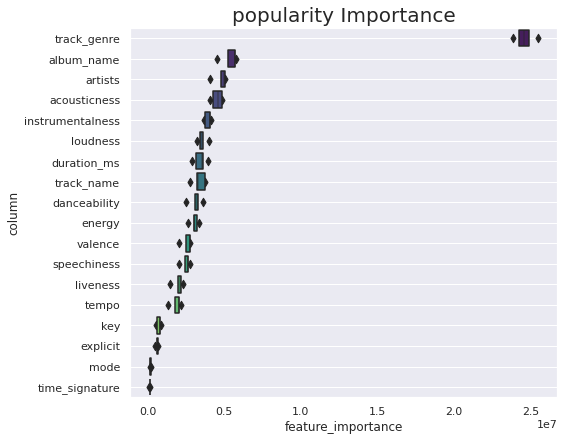

In [102]:
for i in range(1):
    fold = KFold(n_splits=5, shuffle=True, random_state=71)
    ydfi=ydf.iloc[:,i]
    y=np.array(ydfi)
    cv = list(fold.split(train_feat_df, y))
    oof, models = fit_lgbm(train_feat_df.values, y, cv, params=params, verbose=500)
    fig, ax = visualize_importance(models, train_feat_df)
    ax.set_title(target[i]+' Importance',fontsize=20)

In [103]:
preds=[]
for i in range(5):
    preds += [models[i].predict(test_feat_df.values)/5]
predsT=np.array(preds).T
preds2=[]
for item in predsT:
    value=sum(item)
    preds2+=[value]
print(preds2[0:5])

[10.922766440572998, 44.13450644780848, 46.871402856047226, 18.20335666500906, 41.57615410968191]


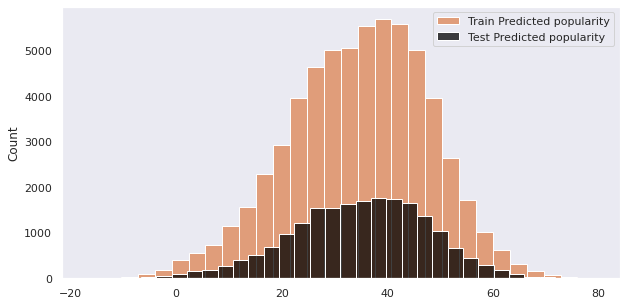

In [104]:
#Visualize test predications against training data
for i in range(1):
    fig, ax = plt.subplots(figsize=(10,5))
    sns.histplot(oof, label='Train Predicted '+target[i], ax=ax, color='C1',bins=30)
    sns.histplot(preds2, label='Test Predicted '+target[i], ax=ax, color='black',bins=30)
    ax.legend()
    ax.grid()

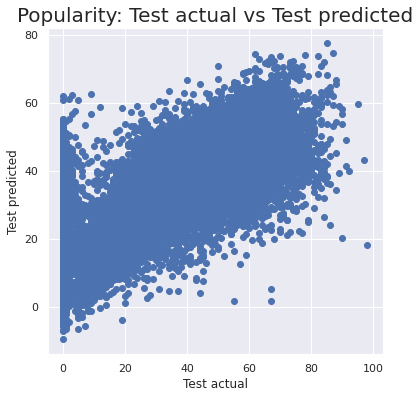

In [105]:
fig,ax = plt.subplots(figsize=(6,6))
ax.set_title('Popularity: Test actual vs Test predicted',fontsize=20)
ax.set_ylabel('Test predicted',fontsize=12)
ax.set_xlabel('Test actual',fontsize=12)
ax.scatter(testY,preds2)
plt.show()

# Categorize the Tracks

In [106]:
# Make deep copy of cleaned df
df.copy(deep=True)

#Remove unneccessary columns and including track_genre
categorise = df[['popularity', 'duration_ms', 'explicit', 'danceability', 'energy',
       'key', 'loudness', 'mode', 'speechiness', 'acousticness',
       'instrumentalness', 'liveness', 'valence', 'tempo', 'time_signature']]

In [107]:
# Standardise the data so that columns with large values do not influence the outcome more than columns with smaller values
scaler = StandardScaler()
scaled_data = scaler.fit_transform(categorise)

In [108]:
# Initialise PCA model
pca = PCA(n_components=.9)

# Get two principal components for the data
df_pca = pca.fit_transform(scaled_data)

In [109]:
# Transform PCA data to a DataFrame
df_pca = pd.DataFrame(
    data=df_pca
)
df_pca.head()

,0,1,2,3,4,5,6,7,8,9,10
0,-0.852700,-1.219146,-0.178641,0.144513,-1.194569,0.154212,1.490760,0.778453,-1.556841,1.018654,0.659096
1,3.022091,-1.733914,-0.316128,-1.087911,-1.000335,0.752039,0.582982,-0.236210,-0.692578,-0.234788,-0.620711
2,1.249899,-0.254606,-0.302296,-1.262446,-1.379778,1.246606,0.958364,0.540133,-0.800917,-0.755290,-0.562128
3,3.420205,-0.341739,-0.043505,-2.343920,-2.180281,0.272340,-1.520287,-0.214309,0.799261,2.238994,0.052884
4,0.710693,-0.818578,-0.902518,-1.060632,-2.175578,1.141692,0.297379,-0.256715,-0.180816,0.179841,0.402474


In [110]:
# Initialise t-SNE model
tsne = TSNE(learning_rate=100)

# Reduce dimensions
tsne_features = tsne.fit_transform(df_pca)
tsne_features.shape

(81344, 2)

In [111]:
# Prepare to plot the dataset

# The first column of transformed features
df_pca['x'] = tsne_features[:,0]

# The second column of transformed features
df_pca['y'] = tsne_features[:,1]

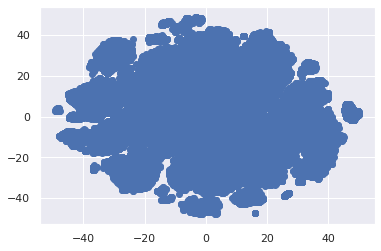

In [112]:
# Visualise the clusters
plt.scatter(df_pca['x'], df_pca['y'])
plt.show()

From the above visualisation it is evident that there are distinctions in the music and there are clusters. Some clusters around the edges are quite distinct from the centre mass.

In [113]:
inertia = []
k = list(range(1, 100))

# Calculate the inertia for the range of k values
for i in k:
    km = KMeans(n_clusters=i, random_state=0)
    km.fit(df_pca)
    inertia.append(km.inertia_)

# Create the Elbow Curve using hvPlot
elbow_data = {"k": k, "inertia": inertia}
df_elbow = pd.DataFrame(elbow_data)
df_elbow.head()

,k,inertia
0,1,7.698302e+07
1,2,4.795683e+07
2,3,3.137557e+07
3,4,2.294913e+07
4,5,1.864055e+07


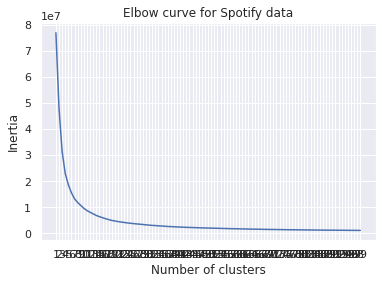

In [128]:
# Plot the elbow curve to find the best candidate(s) for k
plt.plot(df_elbow['k'], df_elbow['inertia'])
plt.xticks(range(1,100))
plt.xlabel('Number of clusters')
plt.ylabel('Inertia')
plt.title('Elbow curve for Spotify data')
plt.show()

In [115]:
def get_clusters(k, data):
    # Initialise the K-Means model
    model = KMeans(n_clusters=k, random_state=0)

    # Train the model
    model.fit(data)

    # Predict clusters
    predictions = model.predict(data)

    # Create return DataFrame with predicted clusters
    data["class"] = model.labels_

    return data

In [132]:
# Get the number of clusters based on the elbow
clusters = get_clusters(50, df_pca)
clusters

,0,1,2,3,4,5,6,7,8,9,10,x,y,class
0,-0.852700,-1.219146,-0.178641,0.144513,-1.194569,0.154212,1.490760,0.778453,-1.556841,1.018654,0.659096,-7.432571,-23.825129,32
1,3.022091,-1.733914,-0.316128,-1.087911,-1.000335,0.752039,0.582982,-0.236210,-0.692578,-0.234788,-0.620711,-9.393929,24.419270,37
2,1.249899,-0.254606,-0.302296,-1.262446,-1.379778,1.246606,0.958364,0.540133,-0.800917,-0.755290,-0.562128,-5.583395,27.033230,37
3,3.420205,-0.341739,-0.043505,-2.343920,-2.180281,0.272340,-1.520287,-0.214309,0.799261,2.238994,0.052884,-30.201904,-14.032803,45
4,0.710693,-0.818578,-0.902518,-1.060632,-2.175578,1.141692,0.297379,-0.256715,-0.180816,0.179841,0.402474,-6.125884,20.717321,37
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
81339,3.261070,2.034867,-0.390074,0.304437,0.624185,1.875705,0.321301,-2.561880,-0.236878,-0.590625,-0.412685,-42.184372,-0.257343,2
81340,4.770098,1.442378,0.211440,0.795325,0.316021,1.362051,0.753467,0.083724,-1.299089,0.847065,-0.645416,30.365936,-28.311790,11
81341,0.951349,-1.169277,-1.082321,0.133324,0.936372,0.281069,0.023217,0.245837,-0.636710,2.108654,-1.171329,36.018879,8.174870,16
81342,0.315741,-0.059712,-0.493091,-0.463949,-0.299590,-0.234875,0.359478,-0.883414,0.749951,0.089387,0.000963,-11.851821,10.552345,48


In [133]:
def show_clusters(df):
    plt.scatter(df['x'], df['y'], c=df['class'])
    plt.show()

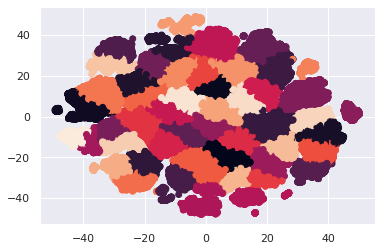

In [134]:
show_clusters(clusters)

It is evident that from the above identified clusters that there is a lot of intermingling of attributes/genres and it is not clear that if the Machine Learning was sone again whether the same outcome would be achieved.